# -------------------- Imports --------------------

In [1]:
import io
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from ipywidgets import FileUpload, Button, VBox, HBox, Output, Label
from IPython.display import display, clear_output
from PIL import Image
import skfuzzy as fuzz
from skfuzzy import control as ctrl

plt.rcParams['figure.figsize'] = (6, 6)

# -------------------- File upload widget (Pilih File) --------------------
# This widget appears immediately after imports as requested.

In [3]:
upload_widget = FileUpload(accept='image/*', multiple=False)
upload_out = Output()

print("Silakan unggah gambar (JPG/PNG). Tombol pilih file di bawah:")


def _on_upload_change(change):
    with upload_out:
        clear_output()
        val = upload_widget.value
        if not val:
            print('Belum ada file.')
            return

        content = None
        name = 'uploaded'

        # Case A: classic dict mapping filename -> {'content': ..., 'metadata': ...}
        if isinstance(val, dict):
            try:
                name = list(val.keys())[0]
                file_info = val[name]
                # some versions store bytes under 'content'
                if isinstance(file_info, dict):
                    content = file_info.get('content')
                    if content is None:
                        # maybe bytes are under 'data' or 'content' as memoryview
                        content = file_info.get('data') or file_info.get('content')
                else:
                    # sometimes value is bytes-like directly
                    content = file_info
            except Exception:
                content = None

        # Case B: newer ipywidgets may give a tuple/list of entries
        if content is None:
            try:
                first = val[0]
                # if it's a dict with 'content'
                if isinstance(first, dict) and 'content' in first:
                    content = first['content']
                    name = first.get('name', name)
                # if it's a two-item tuple like (name, bytes)
                elif isinstance(first, (list, tuple)) and len(first) >= 2 and isinstance(first[1], (bytes, bytearray)):
                    name = first[0]
                    content = first[1]
                # if it's raw bytes or memoryview
                elif isinstance(first, (bytes, bytearray, memoryview)):
                    content = bytes(first)
                else:
                    # last resort: try to get attribute 'content' or 'data'
                    content = getattr(first, 'content', None) or getattr(first, 'data', None)
            except Exception:
                content = None

        if content is None:
            print('Tidak dapat mengekstrak konten file dari widget upload. Versi ipywidgets mungkin berbeda.')
            print('Tipe upload_widget.value:', type(val), '— contoh isi (repr):', repr(val)[:500])
            return

        # Now try to open with PIL
        try:
            pil_img = Image.open(io.BytesIO(content)).convert('RGB')
            np_img_rgb = np.array(pil_img)
            print(f"File berhasil diunggah: {name}")
            plt.imshow(np_img_rgb)
            plt.axis('off')
            plt.title('Gambar Asli (RGB)')
            plt.show()
            # store globally for processing button
            global uploaded_image_rgb, uploaded_image_bgr
            uploaded_image_rgb = np_img_rgb
            uploaded_image_bgr = cv2.cvtColor(np_img_rgb, cv2.COLOR_RGB2BGR)
        except Exception as e:
            print('Gagal membuka gambar:', e)

# Attach handler
try:
    upload_widget.observe(_on_upload_change, names='value')
except Exception:
    # fallback: older/ipython config may require 'on_trait_change'
    try:
        upload_widget.on_trait_change(_on_upload_change, 'value')
    except Exception:
        pass

# Display widget
display(VBox([upload_widget, upload_out]))

Silakan unggah gambar (JPG/PNG). Tombol pilih file di bawah:


# -------------------- Helper functions --------------------

In [ ]:
# Complete single-cell interactive pipeline (upload -> all steps -> fuzzy)
# Paste this entire block into one Jupyter cell and run it.

import io, os, cv2, numpy as np, matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from ipywidgets import FileUpload, Button, VBox, HBox, Output
from IPython.display import display, clear_output
from PIL import Image
import skfuzzy as fuzz
from skfuzzy import control as ctrl

plt.rcParams['figure.figsize'] = (6, 6)

# -------------------- Upload widget --------------------
upload_widget = FileUpload(accept='image/*', multiple=False)
upload_out = Output()

print("Silakan unggah gambar (JPG/PNG). Tombol pilih file di bawah:")

def _on_upload_change(change):
    with upload_out:
        clear_output()
        val = upload_widget.value
        if not val:
            print('Belum ada file.')
            return

        content = None
        name = 'uploaded'
        # dict-case
        if isinstance(val, dict):
            try:
                name = list(val.keys())[0]
                file_info = val[name]
                if isinstance(file_info, dict):
                    content = file_info.get('content') or file_info.get('data')
                else:
                    content = file_info
            except Exception:
                content = None
        # sequence / tuple-case
        if content is None:
            try:
                first = val[0]
                if isinstance(first, dict) and 'content' in first:
                    content = first['content']; name = first.get('name', name)
                elif isinstance(first, (list, tuple)) and len(first) >= 2 and isinstance(first[1], (bytes, bytearray)):
                    name = first[0]; content = first[1]
                elif isinstance(first, (bytes, bytearray)):
                    content = bytes(first)
                else:
                    content = getattr(first, 'content', None) or getattr(first, 'data', None)
            except Exception:
                content = None

        if content is None:
            print('Tidak dapat mengekstrak konten file dari widget upload. Tampilkan repr(value) untuk debug:')
            print(repr(val)[:500])
            return

        try:
            pil_img = Image.open(io.BytesIO(content)).convert('RGB')
            np_img_rgb = np.array(pil_img)
            print(f"File berhasil diunggah: {name}")
            plt.imshow(np_img_rgb); plt.axis('off'); plt.title('Gambar Asli (RGB)'); plt.show()
            global uploaded_image_rgb, uploaded_image_bgr
            uploaded_image_rgb = np_img_rgb
            uploaded_image_bgr = cv2.cvtColor(np_img_rgb, cv2.COLOR_RGB2BGR)
        except Exception as e:
            print('Gagal membuka gambar:', e)

# attach robustly
try:
    upload_widget.observe(_on_upload_change, names='value')
except Exception:
    try:
        upload_widget.on_trait_change(_on_upload_change, 'value')
    except Exception:
        pass

display(VBox([upload_widget, upload_out]))

# -------------------- Helper functions --------------------
def preprocess_image(img_bgr, target_size=(256,256)):
    img = cv2.resize(img_bgr, target_size)
    img = cv2.GaussianBlur(img, (3,3), 0)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return hsv

def segment_image(hsv):
    lower_red1 = np.array([0,40,40], dtype=np.uint8); upper_red1 = np.array([15,255,255], dtype=np.uint8)
    lower_red2 = np.array([160,40,40], dtype=np.uint8); upper_red2 = np.array([180,255,255], dtype=np.uint8)
    lower_green = np.array([35,40,40], dtype=np.uint8); upper_green = np.array([90,255,255], dtype=np.uint8)
    lower_yellow = np.array([20,40,40], dtype=np.uint8); upper_yellow = np.array([45,255,255], dtype=np.uint8)

    mask_red = cv2.bitwise_or(cv2.inRange(hsv, lower_red1, upper_red1), cv2.inRange(hsv, lower_red2, upper_red2))
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = cv2.bitwise_or(mask_red, cv2.bitwise_or(mask_green, mask_yellow))

    bg_light = cv2.inRange(hsv, np.array([0,0,160], dtype=np.uint8), np.array([180,60,255], dtype=np.uint8))
    bg_dark = cv2.inRange(hsv, np.array([0,0,0], dtype=np.uint8), np.array([180,100,50], dtype=np.uint8))
    bg_mask = cv2.bitwise_or(bg_light, bg_dark)
    mask = cv2.bitwise_and(mask, cv2.bitwise_not(bg_mask))

    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    edge_refine = cv2.inRange(hsv, np.array([0,0,130], dtype=np.uint8), np.array([180,70,255], dtype=np.uint8))
    edge_refine = cv2.GaussianBlur(edge_refine, (5,5), 0)
    edge_refine = cv2.dilate(edge_refine, kernel, iterations=1)
    mask = cv2.bitwise_and(mask, cv2.bitwise_not(edge_refine))

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        filled = np.zeros_like(mask)
        cv2.drawContours(filled, [max(contours, key=cv2.contourArea)], -1, 255, -1)
        mask = filled

    mask_blur = cv2.GaussianBlur(mask, (3,3), 0)
    _, mask_final = cv2.threshold(mask_blur, 100, 255, cv2.THRESH_BINARY)
    segmented = cv2.bitwise_and(hsv, hsv, mask=mask_final)
    return segmented, mask_final

def extract_features(segmented_img, mask):
    if mask is None or np.count_nonzero(mask)==0:
        return 0.0,0,0,0.0,0.0,0.0
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return 0.0,0,0,0.0,0.0,0.0
    c = max(contours, key=cv2.contourArea)
    area = float(cv2.contourArea(c))
    x,y,w_box,h_box = cv2.boundingRect(c)
    w_box,h_box = int(w_box), int(h_box)
    k = 0.004
    weight_est = k * area
    hsv = segmented_img.copy()
    if len(hsv.shape)==3:
        h_ch,s_ch,v_ch = cv2.split(hsv)
    else:
        h_ch = s_ch = v_ch = hsv
    x0,y0 = max(0,x), max(0,y)
    x1,y1 = min(hsv.shape[1], x+w_box), min(hsv.shape[0], y+h_box)
    s_crop = s_ch[y0:y1, x0:x1]
    h_crop = h_ch[y0:y1, x0:x1]
    mask_crop = mask[y0:y1, x0:x1]
    if mask_crop is None or mask_crop.size==0 or np.count_nonzero(mask_crop)==0:
        hue_mean = float(np.mean(h_ch[mask>0]) / 180.0) if np.count_nonzero(mask)>0 else 0.0
        return area, w_box, h_box, weight_est, 0.0, hue_mean
    region_s = s_crop[mask_crop>0]
    region_h = h_crop[mask_crop>0]
    if region_s.size==0:
        hue_mean = float(np.mean(region_h)/180.0) if region_h.size>0 else 0.0
        return area, w_box, h_box, weight_est, 0.0, hue_mean
    levels = 64
    s_norm = cv2.normalize(s_crop, None, 0, levels-1, cv2.NORM_MINMAX).astype(np.uint8)
    s_masked = np.where(mask_crop>0, s_norm, 0).astype(np.uint8)
    if np.count_nonzero(mask_crop) < 10:
        contrast = homogeneity = energy = 0.0
    else:
        try:
            glcm = graycomatrix(s_masked, distances=[1,2], angles=[0,np.pi/4,np.pi/2], levels=levels, symmetric=True, normed=True)
            contrast = float(np.mean(graycoprops(glcm, 'contrast')))
            homogeneity = float(np.mean(graycoprops(glcm, 'homogeneity')))
            energy = float(np.mean(graycoprops(glcm, 'energy')))
        except Exception:
            contrast = homogeneity = energy = 0.0
    texture_score = (homogeneity + energy) / 2.0 * (1.0 - contrast/(contrast+1.0))
    hue_mean = float(np.mean(region_h)/180.0) if region_h.size>0 else 0.0
    return area, w_box, h_box, weight_est, float(texture_score), hue_mean

# visualization helpers
def show_rgb(np_img, title=None):
    plt.imshow(np_img); 
    if title: plt.title(title)
    plt.axis('off'); plt.show()

def show_bgr(img_bgr, title=None):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB); show_rgb(img_rgb, title)

def show_hsv_with_channels(hsv_img, title_prefix=None):
    try:
        bgr = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR); show_bgr(bgr, title=(f"{title_prefix} (HSV->BGR)" if title_prefix else None))
    except Exception:
        pass
    if hsv_img.ndim==3:
        h,s,v = cv2.split(hsv_img)
        fig,axes = plt.subplots(1,3,figsize=(12,4))
        axes[0].imshow(h, cmap='hsv'); axes[0].set_title('Hue'); axes[0].axis('off')
        axes[1].imshow(s, cmap='gray'); axes[1].set_title('Saturation'); axes[1].axis('off')
        axes[2].imshow(v, cmap='gray'); axes[2].set_title('Value'); axes[2].axis('off')
        plt.show()

def visualize_glcm(s_masked, levels=64):
    try:
        glcm = graycomatrix(s_masked, distances=[1,2], angles=[0,np.pi/4,np.pi/2], levels=levels, symmetric=True, normed=True)
        glcm_sum = np.sum(glcm, axis=(2,3))
        glcm_sum = glcm_sum / (glcm_sum.max()+1e-12)
        plt.imshow(glcm_sum, cmap='magma'); plt.title('GLCM (summed)'); plt.colorbar(); plt.show()
        contrast = float(np.mean(graycoprops(glcm,'contrast')))
        homogeneity = float(np.mean(graycoprops(glcm,'homogeneity')))
        energy = float(np.mean(graycoprops(glcm,'energy')))
        print(f"GLCM props -> contrast: {contrast:.4f}, homogeneity: {homogeneity:.4f}, energy: {energy:.4f}")
        return contrast, homogeneity, energy
    except Exception as e:
        print("GLCM error:", e); return 0.0,0.0,0.0

# fuzzy controller factories (lazy instantiation safe)
def make_fuzzy_size_ctrl():
    ukuran = ctrl.Antecedent(np.arange(0,1.01,0.01),'ukuran')
    berat = ctrl.Antecedent(np.arange(0,1.01,0.01),'berat')
    tekstur = ctrl.Antecedent(np.arange(0,1.01,0.01),'tekstur')
    grade_out = ctrl.Consequent(np.arange(0,101,1),'grade_out')
    ukuran['kecil']=fuzz.trimf(ukuran.universe,[0.0,0.0,0.35])
    ukuran['sedang']=fuzz.trimf(ukuran.universe,[0.3,0.55,0.7])
    ukuran['besar']=fuzz.trimf(ukuran.universe,[0.6,0.9,1.0])
    berat['rendah']=fuzz.trimf(berat.universe,[0.0,0.0,0.35])
    berat['sedang']=fuzz.trimf(berat.universe,[0.3,0.55,0.7])
    berat['tinggi']=fuzz.trimf(berat.universe,[0.6,0.9,1.0])
    tekstur['kasar']=fuzz.trimf(tekstur.universe,[0.0,0.0,0.25])
    tekstur['normal']=fuzz.trimf(tekstur.universe,[0.2,0.45,0.7])
    tekstur['halus']=fuzz.trimf(tekstur.universe,[0.4,0.7,1.0])
    grade_out['C']=fuzz.trimf(grade_out.universe,[0,0,40])
    grade_out['B']=fuzz.trimf(grade_out.universe,[35,55,75])
    grade_out['A']=fuzz.trimf(grade_out.universe,[60,100,100])
    rules = [
        ctrl.Rule(ukuran['besar'] & berat['tinggi'], grade_out['A']),
        ctrl.Rule(ukuran['sedang'] & berat['tinggi'], grade_out['A']),
        ctrl.Rule(ukuran['besar'] & tekstur['normal'], grade_out['A']),
        ctrl.Rule(berat['tinggi'] & tekstur['halus'], grade_out['A']),
        ctrl.Rule(ukuran['besar'] & tekstur['halus'], grade_out['A']),
        ctrl.Rule(ukuran['sedang'] & berat['sedang'] & tekstur['halus'], grade_out['A']),
        ctrl.Rule(ukuran['sedang'] & berat['sedang'], grade_out['B']),
        ctrl.Rule(ukuran['besar'] & tekstur['kasar'], grade_out['B']),
        ctrl.Rule(ukuran['sedang'] & tekstur['normal'], grade_out['B']),
        ctrl.Rule(berat['rendah'] & tekstur['halus'], grade_out['B']),
        ctrl.Rule(ukuran['besar'] & berat['rendah'], grade_out['B']),
        ctrl.Rule(ukuran['kecil'] & berat['tinggi'], grade_out['B']),
        ctrl.Rule(ukuran['kecil'] | berat['rendah'], grade_out['C']),
        ctrl.Rule(tekstur['kasar'], grade_out['C']),
    ]
    return ctrl.ControlSystem(rules)

def make_fuzzy_texture_ctrl():
    warna = ctrl.Antecedent(np.arange(0,1.01,0.01),'warna')
    tekstur = ctrl.Antecedent(np.arange(0,1.01,0.01),'tekstur')
    kondisi_out = ctrl.Consequent(np.arange(0,101,1),'kondisi_out')
    warna['gelap']=fuzz.trimf(warna.universe,[0.0,0.0,0.35])
    warna['normal']=fuzz.trimf(warna.universe,[0.3,0.55,0.75])
    warna['cerah']=fuzz.trimf(warna.universe,[0.7,1.0,1.0])
    tekstur['kasar']=fuzz.trimf(tekstur.universe,[0.0,0.0,0.3])
    tekstur['normal']=fuzz.trimf(tekstur.universe,[0.25,0.55,0.75])
    tekstur['halus']=fuzz.trimf(tekstur.universe,[0.6,1.0,1.0])
    kondisi_out['rotten']=fuzz.trimf(kondisi_out.universe,[0,0,40])
    kondisi_out['defect']=fuzz.trimf(kondisi_out.universe,[30,55,70])
    kondisi_out['good']=fuzz.trimf(kondisi_out.universe,[60,100,100])
    rules = [
        ctrl.Rule(warna['cerah'] & tekstur['halus'], kondisi_out['good']),
        ctrl.Rule(warna['normal'] & tekstur['normal'], kondisi_out['good']),
        ctrl.Rule(warna['gelap'] & tekstur['halus'], kondisi_out['defect']),
        ctrl.Rule(warna['normal'] & tekstur['kasar'], kondisi_out['defect']),
        ctrl.Rule(warna['gelap'] & tekstur['kasar'], kondisi_out['rotten']),
    ]
    return ctrl.ControlSystem(rules)

# -------------------- Runner UI --------------------
run_button = Button(description='Jalankan pipeline', button_style='success')
process_out = Output()

def on_run_clicked(b):
    with process_out:
        clear_output()
        if 'uploaded_image_bgr' not in globals():
            print('Belum ada gambar yang diunggah. Silakan pilih file terlebih dahulu.'); return

        img_bgr = uploaded_image_bgr.copy()
        print('=== Original ==='); show_bgr(img_bgr, title='Original')

        hsv = preprocess_image(img_bgr)
        print('=== Preprocessing (HSV + channels) ==='); show_hsv_with_channels(hsv, title_prefix='Preprocessed')

        segmented, mask = segment_image(hsv)
        print('=== Segmentation ===')
        plt.imshow(mask, cmap='gray'); plt.title('Mask'); plt.axis('off'); plt.show()
        show_hsv_with_channels(segmented, title_prefix='Segmented')

        area, w_box, h_box, weight_est, texture_score, hue_mean = extract_features(segmented, mask)
        print('Extracted features:'); 
        print(f' area(px)={area:.1f}, bbox={w_box}x{h_box}, weight_est={weight_est:.4f}, texture_score={texture_score:.4f}, hue_mean={hue_mean:.4f}')

        # bbox visuals
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            c = max(contours, key=cv2.contourArea)
            x,y,w,h = cv2.boundingRect(c)
            resized_bgr = cv2.resize(img_bgr, (hsv.shape[1], hsv.shape[0]))
            crop_bgr = resized_bgr[y:y+h, x:x+w].copy()
            crop_mask = mask[y:y+h, x:x+w].copy()
            if crop_bgr.size>0:
                print('Crop (BGR):'); show_bgr(crop_bgr, title='Crop BGR')
            if crop_mask.size>0:
                masked_crop_bgr = cv2.bitwise_and(crop_bgr, crop_bgr, mask=crop_mask); print('Masked crop:'); show_bgr(masked_crop_bgr)
                # GLCM visualize
                _, s_crop, _ = cv2.split(segmented[y:y+h, x:x+w]) if segmented.ndim==3 else (None, segmented[y:y+h,x:x+w], None)
                levels=64
                s_norm = cv2.normalize(s_crop, None, 0, levels-1, cv2.NORM_MINMAX).astype(np.uint8)
                s_masked = np.where(crop_mask>0, s_norm, 0).astype(np.uint8)
                if np.count_nonzero(crop_mask)>0:
                    print('Saturation masked:'); plt.imshow(s_masked, cmap='gray'); plt.axis('off'); plt.show()
                    visualize_glcm(s_masked, levels=levels)
        else:
            print('Tidak ada kontur terdeteksi.')

        # ensure fuzzy controllers exist (lazy create)
        global size_ctrl, texture_ctrl
        if 'size_ctrl' not in globals():
            size_ctrl = make_fuzzy_size_ctrl()
        if 'texture_ctrl' not in globals():
            texture_ctrl = make_fuzzy_texture_ctrl()

        # normalize and fuzzy
        img_area_max = hsv.shape[0]*hsv.shape[1]
        area_norm = np.clip(area/float(img_area_max), 0.0, 1.0)
        k = 0.004
        weight_norm = np.clip(weight_est/(k*img_area_max + 1e-9), 0.0, 1.0)
        texture_norm = np.clip(texture_score, 0.0, 1.0)
        hue_norm = np.clip(hue_mean, 0.0, 1.0)
        print('Normalized inputs:', f'area_norm={area_norm:.4f}', f'weight_norm={weight_norm:.4f}', f'texture_norm={texture_norm:.4f}', f'hue_norm={hue_norm:.4f}')

        sim = ctrl.ControlSystemSimulation(size_ctrl)
        sim.input['ukuran'] = float(area_norm); sim.input['berat'] = float(weight_norm); sim.input['tekstur'] = float(texture_norm)
        try:
            sim.compute(); grade_score = sim.output['grade_out']
        except Exception as e:
            print('Fuzzy(size) compute error:', e); grade_score = 0.0
        grade_label = 'A' if grade_score>=60 else ('B' if grade_score>=40 else 'C')
        print('Size grading:', grade_score, grade_label)

        sim2 = ctrl.ControlSystemSimulation(texture_ctrl)
        sim2.input['warna'] = float(hue_norm); sim2.input['tekstur'] = float(texture_norm)
        try:
            sim2.compute(); tex_score = sim2.output['kondisi_out']
        except Exception as e:
            print('Fuzzy(texture) compute error:', e); tex_score = 0.0
        tex_label = 'Good' if tex_score>=60 else ('Defect' if tex_score>=40 else 'Rotten')
        print('Texture grading:', tex_score, tex_label)

# bind and display
run_button.on_click(on_run_clicked)
display(HBox([run_button])); display(process_out)


Silakan unggah gambar (JPG/PNG). Tombol pilih file di bawah:


Output()

# -------------------- Visualization helpers --------------------

Menampilkan hasil fungsi show_bgr:


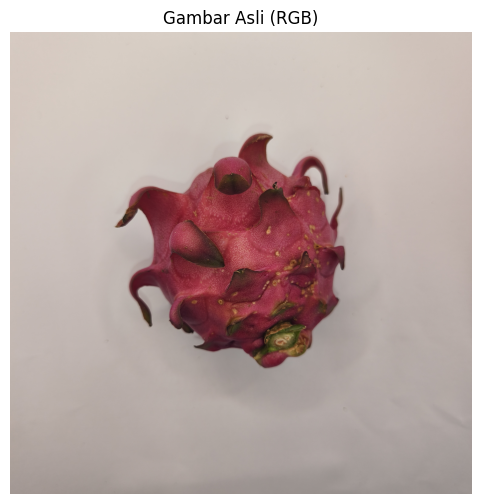

Menampilkan hasil fungsi show_hsv (setelah konversi HSV):


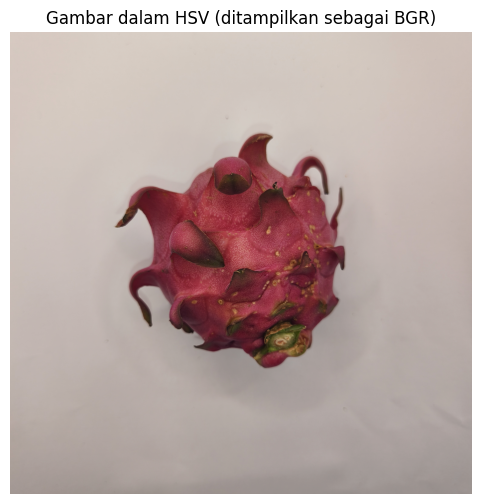

In [11]:
def show_bgr(img_bgr, title=None):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


def show_hsv(hsv_img, title=None):
    try:
        bgr = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
        show_bgr(bgr, title)
    except Exception:
        plt.imshow(hsv_img if hsv_img.ndim==2 else hsv_img[:,:,0], cmap='gray')
        if title: plt.title(title)
        plt.axis('off')
        plt.show()

# Contoh hasil (demonstrasi penggunaan)
if 'uploaded_image_bgr' in globals():
    print('Menampilkan hasil fungsi show_bgr:')
    show_bgr(uploaded_image_bgr, title='Gambar Asli (RGB)')

    print('Menampilkan hasil fungsi show_hsv (setelah konversi HSV):')
    hsv_test = cv2.cvtColor(uploaded_image_bgr, cv2.COLOR_BGR2HSV)
    show_hsv(hsv_test, title='Gambar dalam HSV (ditampilkan sebagai BGR)')
else:
    print('Belum ada gambar yang diunggah. Silakan unggah gambar untuk menampilkan hasil show_bgr dan show_hsv.')


# -------------------- Fuzzy controllers --------------------

In [14]:
def make_fuzzy_size_ctrl():
    ukuran = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'ukuran')
    berat = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'berat')
    tekstur = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'tekstur')
    grade_out = ctrl.Consequent(np.arange(0, 101, 1), 'grade_out')

    ukuran['kecil'] = fuzz.trimf(ukuran.universe, [0.0, 0.0, 0.35])
    ukuran['sedang'] = fuzz.trimf(ukuran.universe, [0.3, 0.55, 0.7])
    ukuran['besar']  = fuzz.trimf(ukuran.universe, [0.6, 0.9, 1.0])

    berat['rendah']  = fuzz.trimf(berat.universe, [0.0, 0.0, 0.35])
    berat['sedang']  = fuzz.trimf(berat.universe, [0.3, 0.55, 0.7])
    berat['tinggi']  = fuzz.trimf(berat.universe, [0.6, 0.9, 1.0])

    tekstur['kasar'] = fuzz.trimf(tekstur.universe, [0.0, 0.0, 0.25])
    tekstur['normal']= fuzz.trimf(tekstur.universe, [0.2, 0.45, 0.7])
    tekstur['halus'] = fuzz.trimf(tekstur.universe, [0.4, 0.7, 1.0])

    grade_out['C'] = fuzz.trimf(grade_out.universe, [0, 0, 40])
    grade_out['B'] = fuzz.trimf(grade_out.universe, [35, 55, 75])
    grade_out['A'] = fuzz.trimf(grade_out.universe, [60, 100, 100])

    rules = [
        ctrl.Rule(ukuran['besar'] & berat['tinggi'], grade_out['A']),
        ctrl.Rule(ukuran['sedang'] & berat['tinggi'], grade_out['A']),
        ctrl.Rule(ukuran['besar'] & tekstur['normal'], grade_out['A']),
        ctrl.Rule(berat['tinggi'] & tekstur['halus'], grade_out['A']),
        ctrl.Rule(ukuran['besar'] & tekstur['halus'], grade_out['A']),
        ctrl.Rule(ukuran['sedang'] & berat['sedang'] & tekstur['halus'], grade_out['A']),

        ctrl.Rule(ukuran['sedang'] & berat['sedang'], grade_out['B']),
        ctrl.Rule(ukuran['besar'] & tekstur['kasar'], grade_out['B']),
        ctrl.Rule(ukuran['sedang'] & tekstur['normal'], grade_out['B']),
        ctrl.Rule(berat['rendah'] & tekstur['halus'], grade_out['B']),
        ctrl.Rule(ukuran['besar'] & berat['rendah'], grade_out['B']),
        ctrl.Rule(ukuran['kecil'] & berat['tinggi'], grade_out['B']),

        ctrl.Rule(ukuran['kecil'] | berat['rendah'], grade_out['C']),
        ctrl.Rule(tekstur['kasar'], grade_out['C']),
    ]

    grading_ctrl = ctrl.ControlSystem(rules)
    return grading_ctrl


def make_fuzzy_texture_ctrl():
    warna = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'warna')
    tekstur = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'tekstur')
    kondisi_out = ctrl.Consequent(np.arange(0, 101, 1), 'kondisi_out')

    warna['gelap'] = fuzz.trimf(warna.universe, [0.0, 0.0, 0.35])
    warna['normal'] = fuzz.trimf(warna.universe, [0.3, 0.55, 0.75])
    warna['cerah'] = fuzz.trimf(warna.universe, [0.7, 1.0, 1.0])

    tekstur['kasar'] = fuzz.trimf(tekstur.universe, [0.0, 0.0, 0.3])
    tekstur['normal'] = fuzz.trimf(tekstur.universe, [0.25, 0.55, 0.75])
    tekstur['halus'] = fuzz.trimf(tekstur.universe, [0.6, 1.0, 1.0])

    kondisi_out['rotten'] = fuzz.trimf(kondisi_out.universe, [0, 0, 40])
    kondisi_out['defect'] = fuzz.trimf(kondisi_out.universe, [30, 55, 70])
    kondisi_out['good'] = fuzz.trimf(kondisi_out.universe, [60, 100, 100])

    rules = [
        ctrl.Rule(warna['cerah'] & tekstur['halus'], kondisi_out['good']),
        ctrl.Rule(warna['normal'] & tekstur['normal'], kondisi_out['good']),
        ctrl.Rule(warna['gelap'] & tekstur['halus'], kondisi_out['defect']),
        ctrl.Rule(warna['normal'] & tekstur['kasar'], kondisi_out['defect']),
        ctrl.Rule(warna['gelap'] & tekstur['kasar'], kondisi_out['rotten']),
    ]

    kondisi_ctrl = ctrl.ControlSystem(rules)
    return kondisi_ctrl

# instantiate controllers
size_ctrl = make_fuzzy_size_ctrl()
texture_ctrl = make_fuzzy_texture_ctrl()


# -------------------- Interactive pipeline runner --------------------

In [ ]:
run_button = Button(description='Jalankan pipeline', button_style='success')
process_out = Output()


def on_run_clicked(b):
    with process_out:
        clear_output()
        # check uploaded image
        if 'uploaded_image_bgr' not in globals():
            print('Belum ada gambar yang diunggah. Silakan pilih file terlebih dahulu.')
            return

        img_bgr = uploaded_image_bgr.copy()
        print('Menjalankan pipeline untuk gambar yang diunggah...')

        # show original (RGB view)
        print('Original:')
        show_bgr(img_bgr, title='Original (RGB view)')

        # preprocessing
        hsv = preprocess_image(img_bgr)
        print('Setelah preprocessing (HSV visualisasi):')
        show_hsv(hsv, title='Preprocessed (HSV -> BGR shown)')

        # segmentation
        segmented, mask = segment_image(hsv)
        print('Mask segmentasi:')
        plt.imshow(mask, cmap='gray')
        plt.title('Mask (biner)')
        plt.axis('off')
        plt.show()

        print('Hasil segmentasi (HSV visualized):')
        show_hsv(segmented, title='Segmented (HSV)')

        # feature extraction
        area, w_box, h_box, weight_est, texture_score, hue_mean = extract_features(segmented, mask)
        print('Fitur yang diekstraksi:')
        print(f'  area (px): {area:.1f}')
        print(f'  bbox: {w_box} x {h_box} px')
        print(f'  weight_est (empirik): {weight_est:.4f}')
        print(f'  texture_score: {texture_score:.4f}')
        print(f'  hue_mean (0..1): {hue_mean:.4f}')

        # normalize for fuzzy
        img_area_max = hsv.shape[0] * hsv.shape[1]
        area_norm = np.clip(area / float(img_area_max), 0.0, 1.0)
        k = 0.004
        weight_norm = np.clip(weight_est / (k * img_area_max + 1e-9), 0.0, 1.0)
        texture_norm = np.clip(texture_score, 0.0, 1.0)
        hue_norm = np.clip(hue_mean, 0.0, 1.0)

        print('Nilai normalisasi untuk fuzzy:')
        print(f'  area_norm: {area_norm:.4f}')
        print(f'  weight_norm: {weight_norm:.4f}')
        print(f'  texture_norm: {texture_norm:.4f}')
        print(f'  hue_norm: {hue_norm:.4f}')

        # fuzzy grading size
        sim = ctrl.ControlSystemSimulation(size_ctrl)
        sim.input['ukuran'] = float(area_norm)
        sim.input['berat'] = float(weight_norm)
        sim.input['tekstur'] = float(texture_norm)
        try:
            sim.compute()
            grade_score = sim.output['grade_out']
        except Exception as e:
            print('Error fuzzy (size):', e)
            grade_score = 0.0

        if grade_score >= 60:
            grade_label = 'A'
        elif grade_score >= 40:
            grade_label = 'B'
        else:
            grade_label = 'C'

        print('Hasil grading (ukuran/berat/tekstur):')
        print(f'  grade_score: {grade_score:.2f}')
        print(f'  grade_label: {grade_label}')

        # fuzzy grading texture-color
        sim2 = ctrl.ControlSystemSimulation(texture_ctrl)
        sim2.input['warna'] = float(hue_norm)
        sim2.input['tekstur'] = float(texture_norm)
        try:
            sim2.compute()
            tex_score = sim2.output['kondisi_out']
        except Exception as e:
            print('Error fuzzy (texture):', e)
            tex_score = 0.0

        if tex_score >= 60:
            tex_label = 'Good'
        elif tex_score >= 40:
            tex_label = 'Defect'
        else:
            tex_label = 'Rotten'

        print('Penilaian warna & tekstur:')
        print(f'  texture_grade_score: {tex_score:.2f}')
        print(f'  texture_grade_label: {tex_label}')

# bind button
run_button.on_click(on_run_clicked)

display(HBox([run_button]))
display(process_out)

Output()